### Tratamiento de datos

Librerías utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Reshape, LSTM, Dropout, Flatten, Conv2D, MaxPool2D, Input, RepeatVector, TimeDistributed
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint

Definición de constantes

In [2]:
Corr_SP = [50,50,50,50,50] # corrientes minimas para detección de barra C3, C4, C5, C6, C7

Función para eliminación de fecha y organizar la hora en segundos

In [3]:
def ElimFechaDF(df):
    df['DateTime'] = df['DateTime'].str.replace(".000", ".001")
    df['DateTime'] = pd.to_datetime(df['DateTime']).dt.time
    df['DateTime'] = pd.to_datetime(df['DateTime'], format='%H:%M:%S.%f').dt.time
    df['DateTime'] = df['DateTime'].apply(lambda dt: dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond/1000000)
    primer_valor = df['DateTime'].iloc[0]
    df['DateTime'] = df['DateTime'] - primer_valor
    return df

Función de interpolación de las corrientes

In [4]:
def InterpolArr(df):
    Sal_array = []
    xv = df["DateTime"].to_numpy()
    yv1 = df["TL2.SP.AN2L_TCONT_CORRIENTE_REAL_CAJA3"].to_numpy()
    yv2 = df["TL2.SP.AN2L_TCONT_CORRIENTE_REAL_CAJA4"].to_numpy()
    yv3 = df["TL2.SP.AN2L_TCONT_CORRIENTE_REAL_CAJA5"].to_numpy()
    yv4 = df["TL2.SP.AN2L_TCONT_CORRIENTE_REAL_CAJA6"].to_numpy()
    yv5 = df["TL2.SP.AN2L_TCONT_CORRIENTE_REAL_CAJA7"].to_numpy()
    x = np.array(range(0,3590))
    y1 = np.interp(x, xv, yv1)
    y2 = np.interp(x, xv, yv2)
    y3 = np.interp(x, xv, yv3)
    y4 = np.interp(x, xv, yv4)
    y5 = np.interp(x, xv, yv5)

    Sal_array.append(x)
    Sal_array.append(y1)
    Sal_array.append(y2)
    Sal_array.append(y3)
    Sal_array.append(y4)
    Sal_array.append(y5)
    return np.array(Sal_array)


In [5]:
def GrafArray(Corr_interp):
# Iterar sobre los DataFrames y mostrar las gráficas

    for i, cint in enumerate(Corr_interp):
        # Crear una nueva figura y subparcela para cada DataFrame
        fig, ax = plt.subplots()
        
        # Trama de las variables en función del tiempo
        for column in range(0,5):
            
            ax.plot(cint[0,:], cint[column+1,:], label=column)
        
        # Agregar título y etiquetas de ejes
        ax.set_title(f'Gráfica Corrientes de 1" {i+1}')
        ax.set_xlabel('Tiempo (s)')
        ax.set_ylabel('Corriente (A)')
        
        # Agregar una leyenda
        ax.legend()
        fig.set_size_inches(22, 4)
        # Mostrar la gráfica
        plt.show()

In [6]:
def timepoBarra(Corr_array,CrrUp):
    time = []

    barra_on = 0
    for i in range(1,5):
        for j in range(0, Corr_array[i].size-1):
            if Corr_array[i][j] > CrrUp[i] and barra_on != 1:
                barra_on = 1
                kini= j
            if barra_on == 1 and Corr_array[i][j] < CrrUp[i]:
                time.append(j-kini)
                barra_on = 0
    return time

In [7]:
def normalizar_array(array):
    total_sinal, dimen_senal, tamano_senal = array.shape
        
    for k in range(total_sinal):
        for j in range(1,dimen_senal):
            min_val = np.min(array[k][j])
            max_val = np.max(array[k][j])
            array[k][j] = (array[k][j] - min_val) / (max_val - min_val)
    return array


In [20]:
def normalizar_array_2(array):
    total_sinal, tamano_senal = array.shape
        
    for k in range(total_sinal):
        min_val = np.min(array[k])
        max_val = np.max(array[k])
        array[k] = (array[k] - min_val) / (max_val - min_val)
    return array

In [8]:
def PruebaEmpirica(Arr):
    corrmin = 50
    corrmax = 700
    timemin= 28
    timemax= 36
    barra_on = 0
    time = []
    for i in range(1,5):
        for j in range(0, Arr[i].size-1):
            if Arr[i][j] > corrmax:
                Estado = "Falla"
                print(Estado, " Por Corriente maxima: ", i," -- ",Arr[i][j])
            if Arr[i][j] > corrmin and barra_on != 1:
                barra_on = 1
                kini= j
            if barra_on == 1 and Arr[i][j] < corrmin:
                if ((j-kini) < timemin) or ((j-kini) > timemax):
                    Estado = "Falla"
                    print(Estado, " Por tiempo inadecuado con barra: ", (j-kini), "s")
                else:
                    Estado = "Barra ok"
                    print(Estado)
                time.append(j-kini)
                barra_on = 0
    return Estado, time



In [9]:
def dividir_senal(senal, n=100):
    total_sinal, dimen_senal, tamano_senal = senal.shape
    tamano_subarray = n
    numero_subarrays = tamano_senal // tamano_subarray

    subarrays = []
    for k in range(total_sinal):
        for j in range(1,dimen_senal):

            for i in range(numero_subarrays):
                inicio = i * tamano_subarray
                fin = inicio + tamano_subarray
                subarray = senal[k][j][inicio:fin]
                subarrays.append(subarray)

    return np.array(subarrays)

In [46]:
def dividir_senal_2(senal, n=100):
    total_sinal, tamano_senal = senal.shape
    tamano_subarray = n
    numero_subarrays = tamano_senal // tamano_subarray

    subarrays = []
    for k in range(total_sinal):

        for i in range(numero_subarrays):
            inicio = i * tamano_subarray
            fin = inicio + tamano_subarray
            subarray = senal[k][inicio:fin]
            if (max(subarray) != 0) and (subarray[0]!=0)and (subarray[-1]!=0):
                subarrays.append(subarray)

    return np.array(subarrays)

In [10]:
def CrearModelo(input_shape):
    model = Sequential()

    # Encoder
    model.add(LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(32, activation='relu'))

    # Repetir el vector latente en cada paso de tiempo
    model.add(RepeatVector(input_shape[0]))

    # Decoder
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(input_shape[1])))
    model.compile(optimizer='adam', loss='mse')
    return model

Importar datos de csv

In [11]:
Corriente1 = pd.read_csv(r'1.csv', sep=';')
Corriente2 = pd.read_csv(r'2.csv', sep=';')
Corriente3 = pd.read_csv(r'3.csv', sep=';')
Corriente4 = pd.read_csv(r'4.csv', sep=';')
Corriente5 = pd.read_csv(r'5.csv', sep=';')
Corriente6 = pd.read_csv(r'6.csv', sep=';')
Corriente7 = pd.read_csv(r'7.csv', sep=';')
Corriente8 = pd.read_csv(r'8.csv', sep=';')
Corriente9 = pd.read_csv(r'9.csv', sep=';')
Corriente10 = pd.read_csv(r'10.csv', sep=';')
Corriente1 = ElimFechaDF(Corriente1)
Corriente2 = ElimFechaDF(Corriente2)
Corriente3 = ElimFechaDF(Corriente3)
Corriente4 = ElimFechaDF(Corriente4)
Corriente5 = ElimFechaDF(Corriente5)
Corriente6 = ElimFechaDF(Corriente6)
Corriente7 = ElimFechaDF(Corriente7)
Corriente8 = ElimFechaDF(Corriente8)
Corriente9 = ElimFechaDF(Corriente9)
Corriente10 = ElimFechaDF(Corriente10)
Corriente1.head()

C:\Users\Carlos\AppData\Local\Temp\ipykernel_19888\3584001430.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['DateTime'] = df['DateTime'].str.replace(".000", ".001")
C:\Users\Carlos\AppData\Local\Temp\ipykernel_19888\3584001430.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['DateTime'] = df['DateTime'].str.replace(".000", ".001")
C:\Users\Carlos\AppData\Local\Temp\ipykernel_19888\3584001430.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['DateTime'] = df['DateTime'].str.replace(".000", ".001")
C:\Users\Carlos\AppData\Local\Temp\ipykernel_19888\3584001430.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['DateTime'] = df['DateTime'].str.replace(".000", ".001")
C:\Users\Carlos\AppData\Local\Temp\ipykernel_19888\3584001430.py:2: FutureWarning: The default value of 

DateTime  TL2.SP.AN2L_TCONT_CORRIENTE_REAL_CAJA3  \
0     0.000                                      22   
1     0.609                                      37   
2     6.521                                      37   
3     7.739                                      23   
4    12.792                                      42   

   TL2.SP.AN2L_TCONT_CORRIENTE_REAL_CAJA4  \
0                                      11   
1                                      21   
2                                      21   
3                                       8   
4                                      22   

   TL2.SP.AN2L_TCONT_CORRIENTE_REAL_CAJA5  \
0                                      18   
1                                       8   
2                                      10   
3                                       7   
4                                      24   

   TL2.SP.AN2L_TCONT_CORRIENTE_REAL_CAJA6  \
0                                      25   
1                                      23   
2                                       8   
3                                       9   
4                                      26   

   TL2.SP.AN2L_TCONT_CORRIENTE_REAL_CAJA7  
0                                      70  
1                                      36  
2                                      33  
3                                      33  
4                                      37

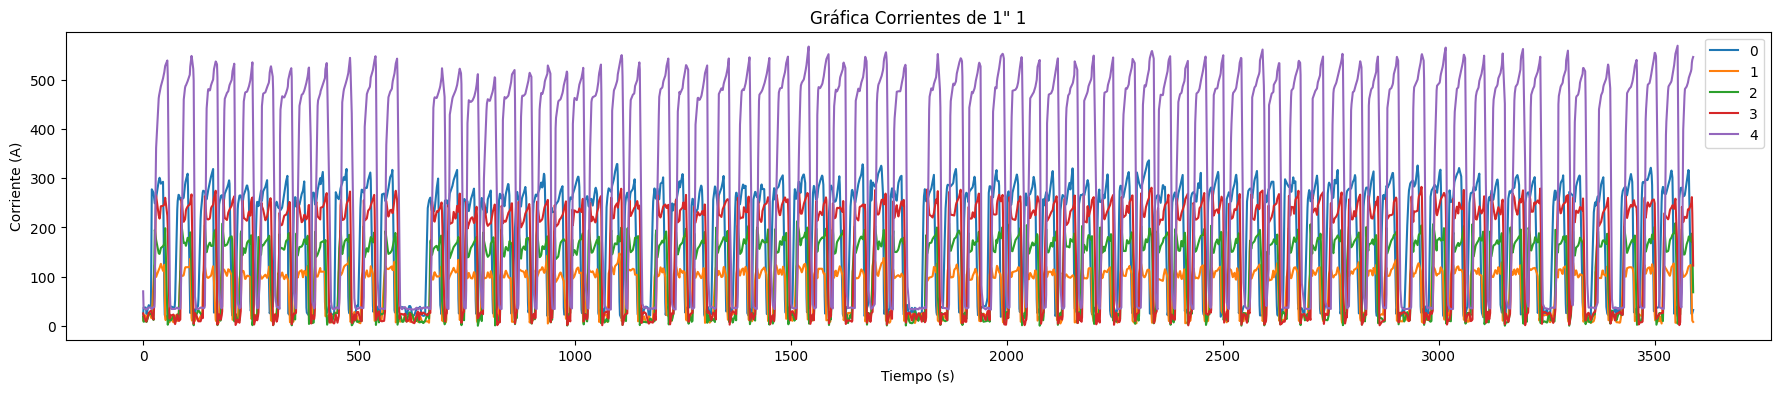

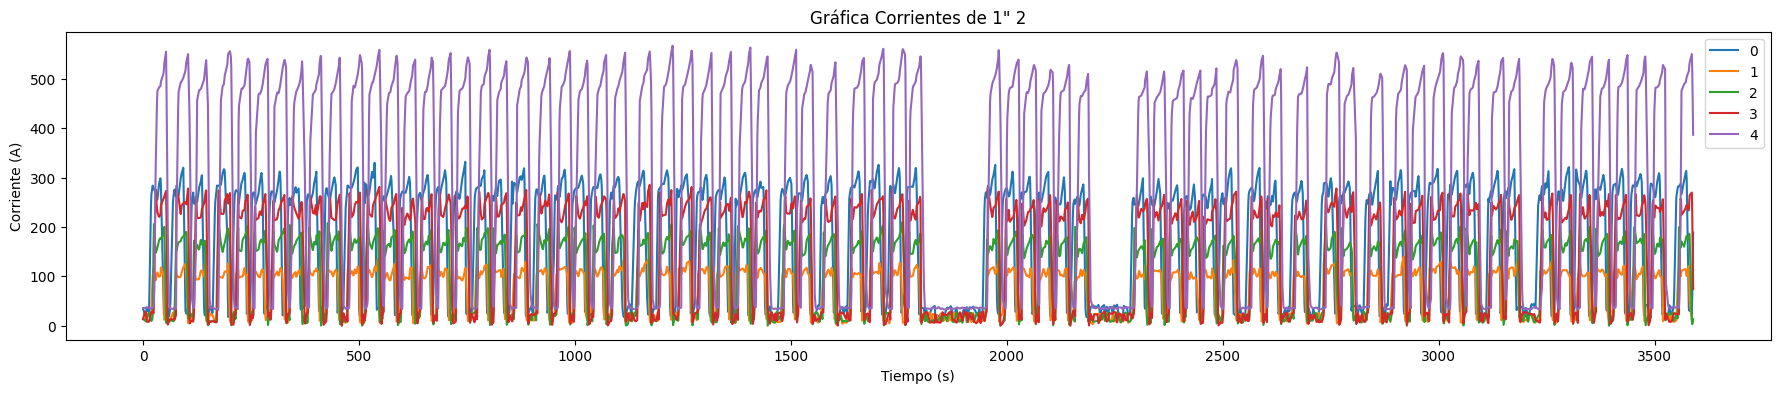

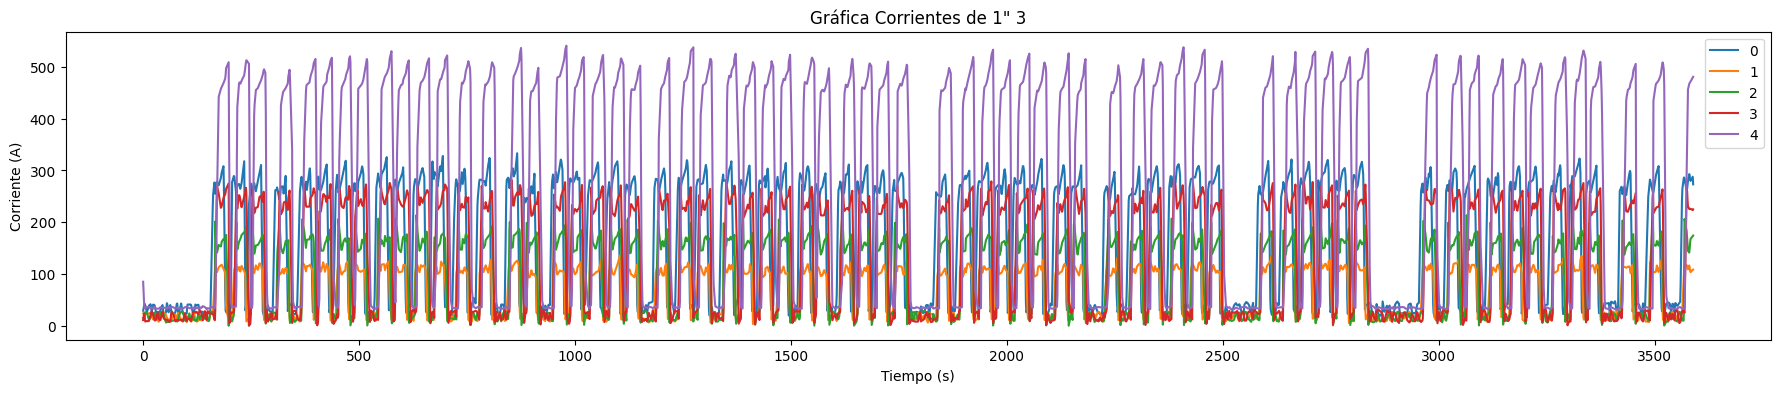

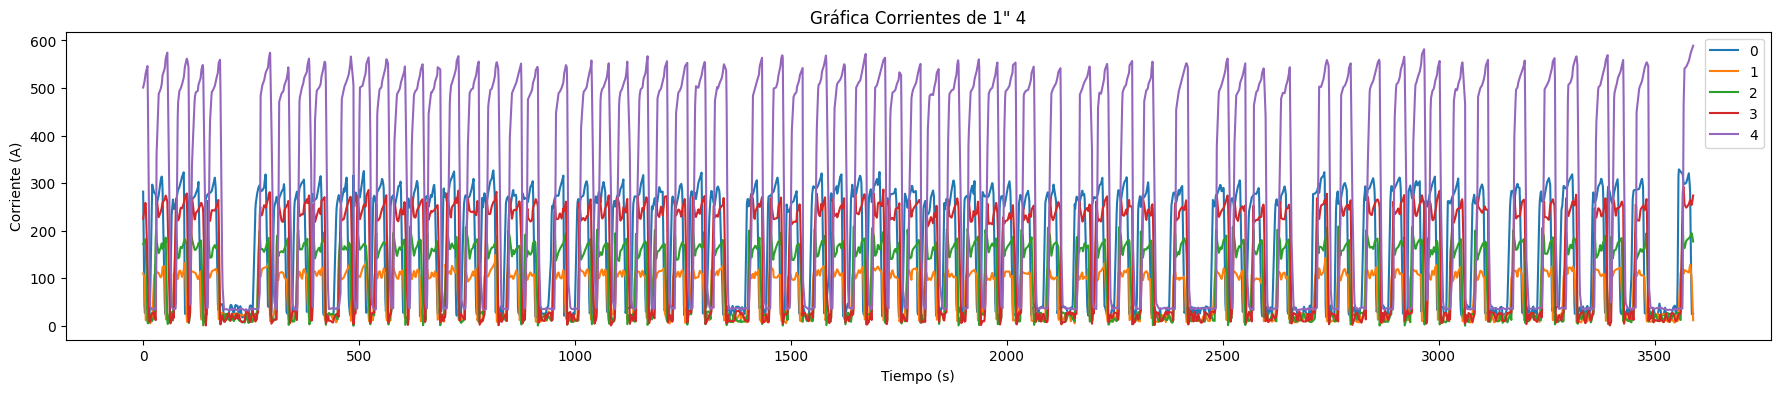

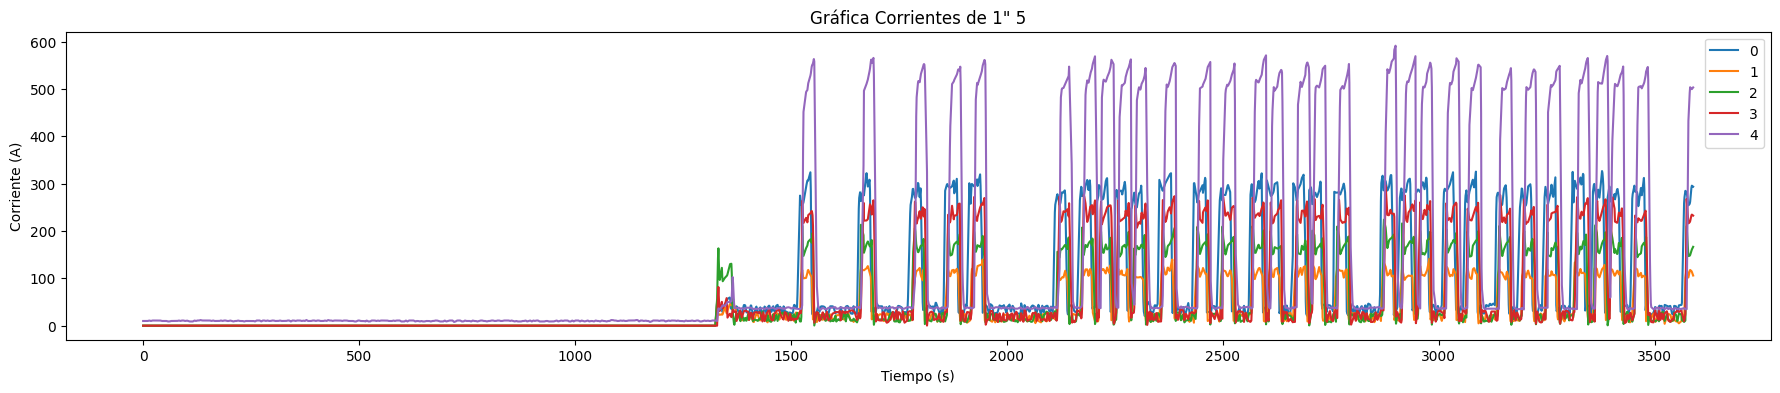

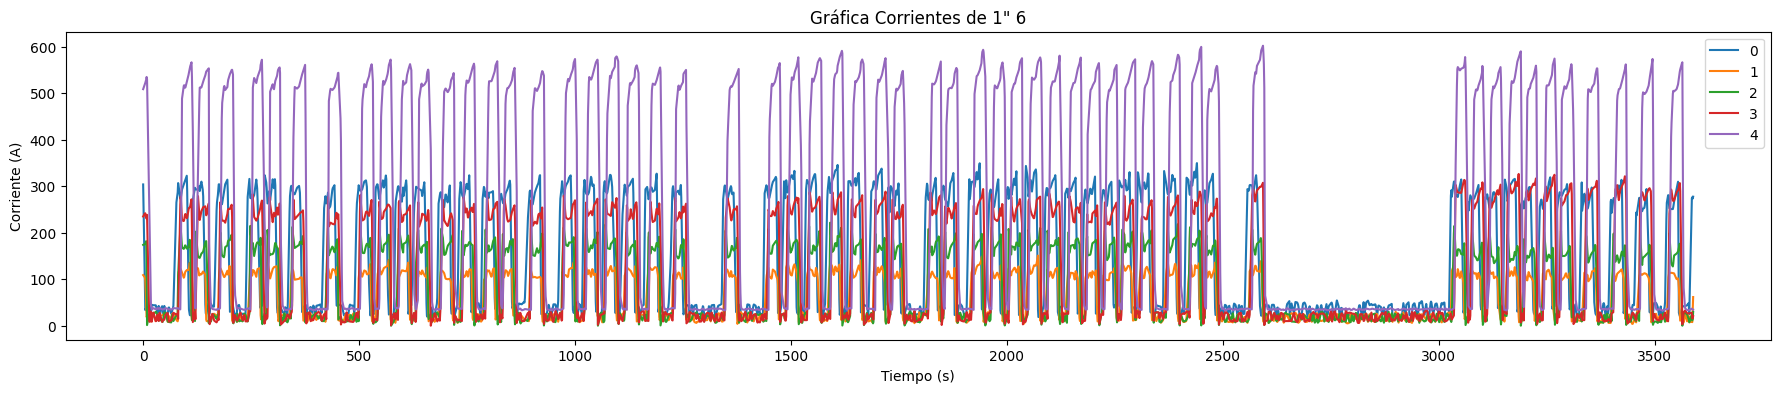

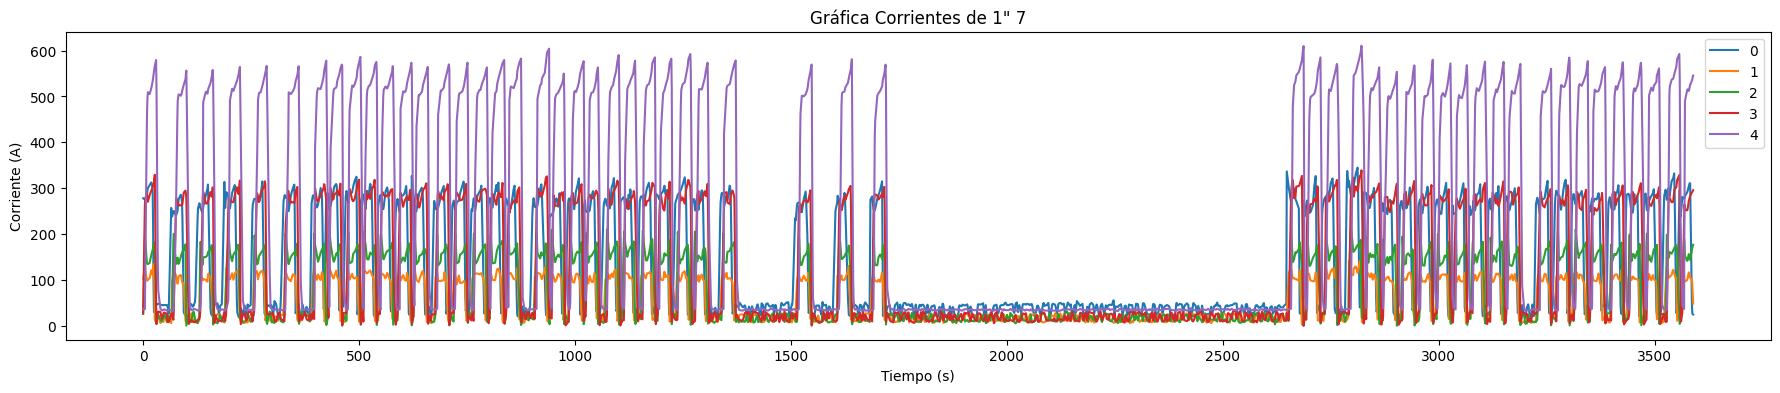

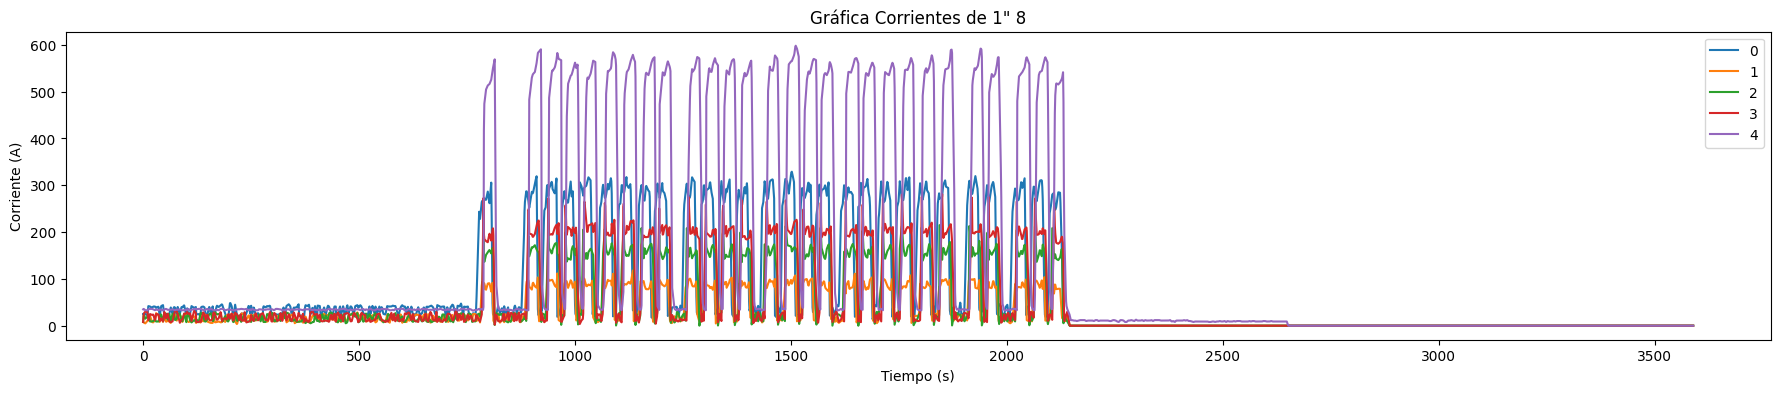

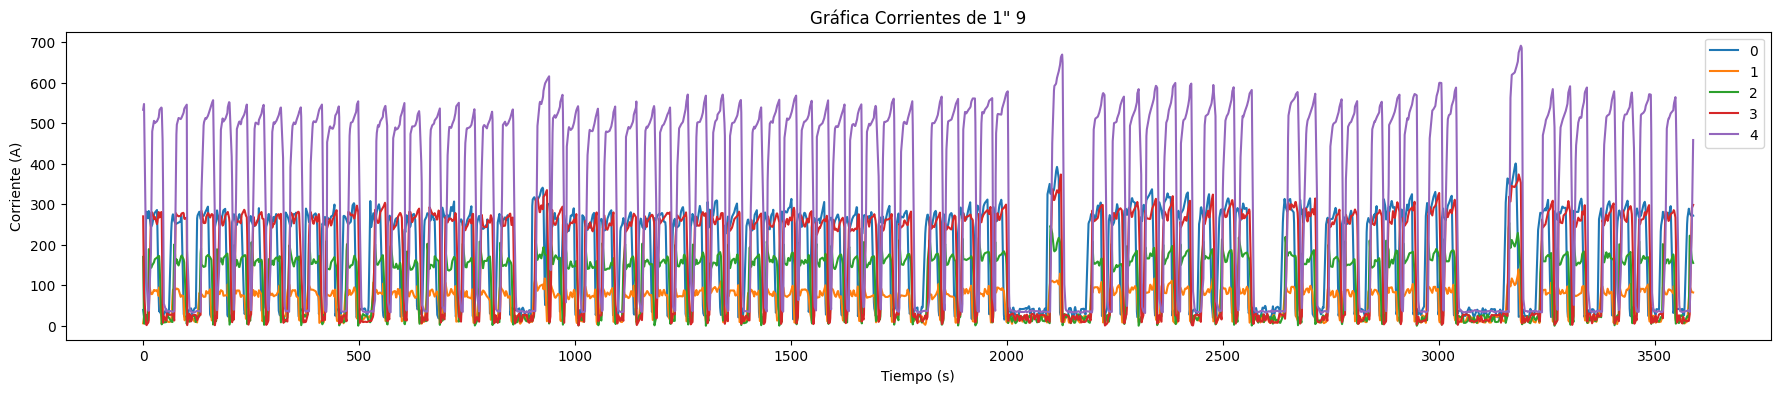

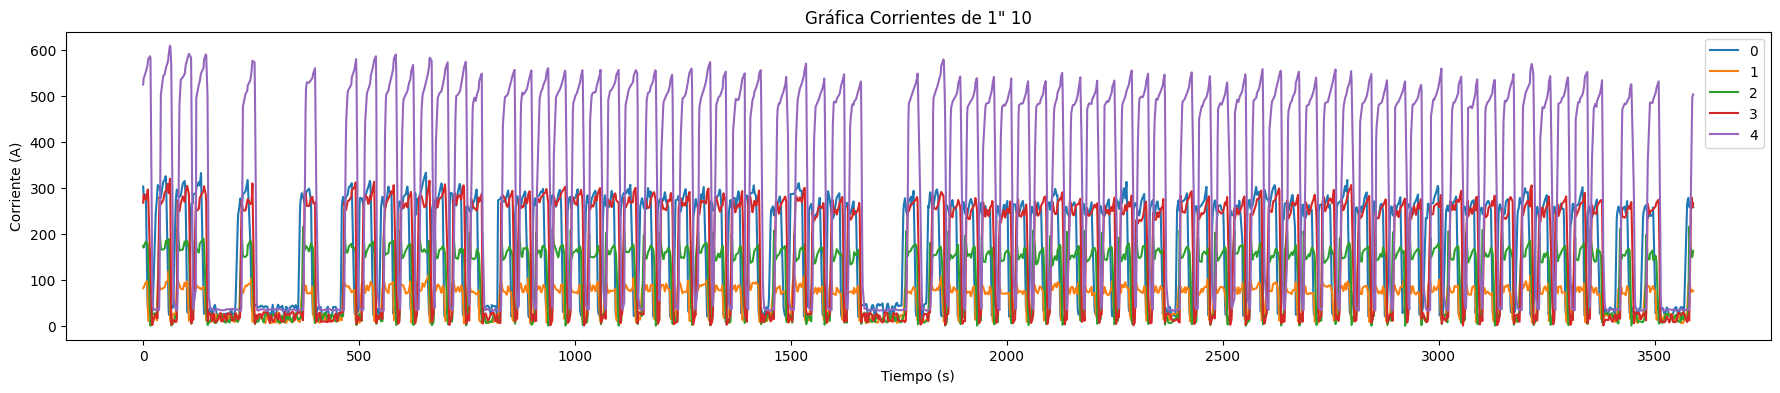

In [12]:
Corr_interp = np.array([InterpolArr(Corriente1), InterpolArr(Corriente2), InterpolArr(Corriente3), InterpolArr(Corriente4), InterpolArr(Corriente5), InterpolArr(Corriente6), InterpolArr(Corriente7), InterpolArr(Corriente8), InterpolArr(Corriente9), InterpolArr(Corriente10)])  

GrafArray(Corr_interp)

Estudio de Tiempo de barra en proceso

28.0 36.0


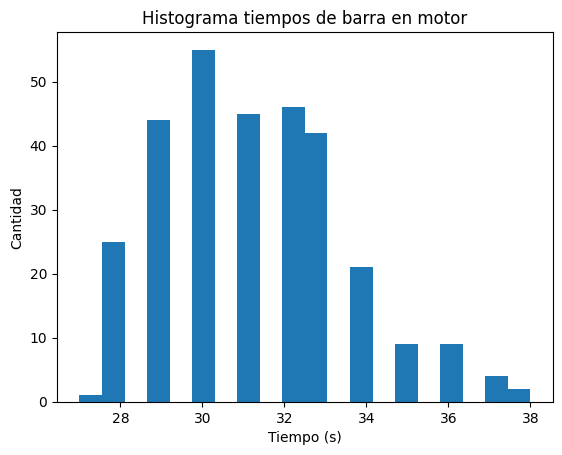

In [13]:
timeC = np.array(timepoBarra(Corr_interp[0],Corr_SP))
timeC[227]=30
minTime, maxTime = np.percentile(timeC,3),np.percentile(timeC,98)
print(minTime, maxTime)
plt.hist(timeC, 20)
plt.ylabel('Cantidad')
plt.xlabel('Tiempo (s)')
plt.title('Histograma tiempos de barra en motor')
plt.show()


Se ejecuta la prueba empirica con corriente 1

In [14]:
EstadoB, TiempoB1 = PruebaEmpirica(InterpolArr(Corriente1)) 

Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Falla  Por tiempo inadecuado con barra:  38 s
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Falla  Por tiempo inadecuado con barra:  37 s
Falla  Por tiempo inadecuado con barra:  37 s
Falla  Por tiempo inadecuado con barra:  37 s
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Falla  Por tiempo inadecuado con barra:  38 s
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Falla  Por tiempo inadecuado con barra:  37 s
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Barra ok
Falla  Por tiempo inadecuado con barra: 

Entrenamiento del Modelo con X_train

In [47]:
Corr_interp = np.array([InterpolArr(Corriente1), InterpolArr(Corriente2), InterpolArr(Corriente3), InterpolArr(Corriente4), InterpolArr(Corriente5), InterpolArr(Corriente6), InterpolArr(Corriente7), InterpolArr(Corriente8), InterpolArr(Corriente9), InterpolArr(Corriente10)])  
C_C3_int = Corr_interp[:,1,:]
C_C4_int = Corr_interp[:,2,:]
C_C5_int = Corr_interp[:,3,:]
C_C6_int = Corr_interp[:,4,:]
C_C7_int = Corr_interp[:,5,:]
X_train_c3 = dividir_senal_2(normalizar_array_2(C_C3_int))
X_train_c4 = dividir_senal_2(normalizar_array_2(C_C4_int))
X_train_c5 = dividir_senal_2(normalizar_array_2(C_C5_int))
X_train_c6 = dividir_senal_2(normalizar_array_2(C_C6_int))
X_train_c7 = dividir_senal_2(normalizar_array_2(C_C7_int))
print(X_train_c3)
#X_train = dividir_senal(normalizar_array(Corr_interp))



[[0.02162202 0.06827764 0.06827764 ... 0.84546781 0.86293361 0.87518607]
 [0.88541987 0.89530856 0.90519725 ... 0.8488145  0.86106365 0.87337974]
 [0.85159696 0.69593827 0.54027958 ... 0.06746842 0.06935617 0.07124391]
 ...
 [0.89370181 0.87489774 0.86487829 ... 0.03583371 0.0337788  0.03172389]
 [0.06194147 0.17985864 0.29777581 ... 0.07835033 0.07664634 0.07494235]
 [0.07323836 0.07153437 0.06997675 ... 0.67848891 0.54866616 0.41884342]]


In [49]:

modelo_c3 = CrearModelo((100, 1))
modelo_c4 = CrearModelo((100, 1))
modelo_c5 = CrearModelo((100, 1))
modelo_c6 = CrearModelo((100, 1))
modelo_c7 = CrearModelo((100, 1))

nb_epochs = 5000
batch_size = 32



history_c3 = modelo_c3.fit(X_train_c3, X_train_c3, epochs=nb_epochs, batch_size=batch_size).history
modelo_c3.save("model_c3.h5")

history_c4 = modelo_c4.fit(X_train_c4, X_train_c4, epochs=nb_epochs, batch_size=batch_size).history
modelo_c4.save("model_c4.h5")

history_c5 = modelo_c5.fit(X_train_c5, X_train_c5, epochs=nb_epochs, batch_size=batch_size).history
modelo_c5.save("model_c5.h5")

history_c6 = modelo_c6.fit(X_train_c6, X_train_c6, epochs=nb_epochs, batch_size=batch_size).history
modelo_c6.save("model_c6.h5")

history_c7 = modelo_c7.fit(X_train_c7, X_train_c7, epochs=nb_epochs, batch_size=batch_size).history
modelo_c7.save("model_c7.h5")

Epoch 1/1000
11/11 [==============================] - 19s 148ms/step - loss: 0.3074
Epoch 2/1000
11/11 [==============================] - 1s 114ms/step - loss: 0.1685
Epoch 3/1000
11/11 [==============================] - 1s 115ms/step - loss: 0.1292
Epoch 4/1000
11/11 [==============================] - 1s 113ms/step - loss: 0.1259
Epoch 5/1000
11/11 [==============================] - 1s 132ms/step - loss: 0.1253
Epoch 6/1000
11/11 [==============================] - 1s 138ms/step - loss: 0.1251
Epoch 7/1000
11/11 [==============================] - 1s 115ms/step - loss: 0.1243
Epoch 8/1000
11/11 [==============================] - 1s 120ms/step - loss: 0.1222
Epoch 9/1000
11/11 [==============================] - 2s 143ms/step - loss: 0.1199
Epoch 10/1000
11/11 [==============================] - 2s 146ms/step - loss: 0.1206
Epoch 11/1000
11/11 [==============================] - 2s 144ms/step - loss: 0.1199
Epoch 12/1000
11/11 [==============================] - 1s 131ms/step - loss: 0.1180


[0.30735844373703003, 0.16848070919513702, 0.12922827899456024, 0.12587030231952667, 0.12529407441616058, 0.12511706352233887, 0.12430359423160553, 0.12221171706914902, 0.11988979578018188, 0.12060384452342987, 0.1199188381433487, 0.11798208206892014, 0.1160794124007225, 0.11527031660079956, 0.11472868174314499, 0.12026453763246536, 0.11488736420869827, 0.11318080127239227, 0.11124090850353241, 0.11047600209712982, 0.10938969999551773, 0.10809653997421265, 0.1065000668168068, 0.11105626076459885, 0.1235344335436821, 0.11878615617752075, 0.1178639605641365, 0.11734392493963242, 0.11691562831401825, 0.1158083826303482, 0.11493385583162308, 0.11477348208427429, 0.11306975781917572, 0.11136157810688019, 0.10931111872196198, 0.10853512585163116, 0.1066368967294693, 0.10639363527297974, 0.10456036776304245, 0.1044071763753891, 0.10408567637205124, 0.10463612526655197, 0.10389964282512665, 0.1036427766084671, 0.10373993217945099, 0.10353558510541916, 0.10290597379207611, 0.10321368277072906, 

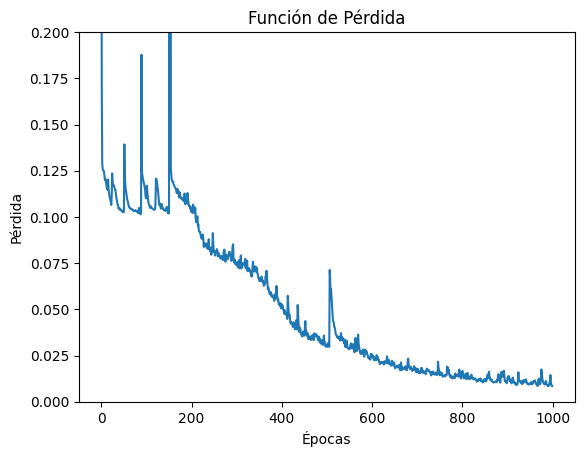

In [57]:
loss = history_c3['loss']
print(loss)
# Graficar la función de pérdida
plt.plot(loss)
plt.title('Función de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.ylim(0, 0.2)
plt.show()

Visualizar La reconstrucción con Autoencoder del X_train

1/1 [==============================] - 1s 1s/step
Error de predicción:
0.2462349278894666


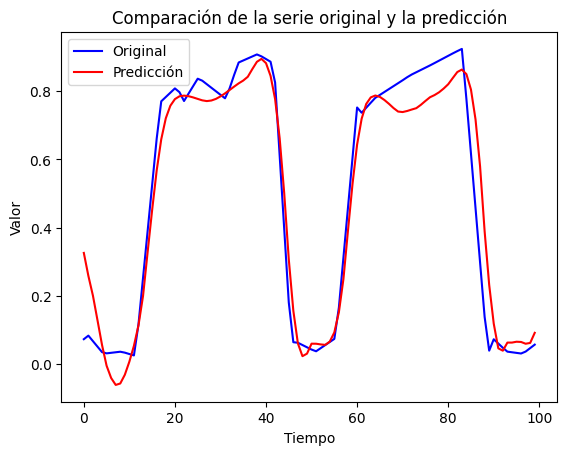

In [51]:
serie_input = np.expand_dims(X_train_c3[100], axis=0) 


prediccion = modelo_c3.predict(serie_input)

# Calcular el error entre la serie original y la predicción
mse = np.mean((serie_input - prediccion) ** 2)


# Imprimir el resultado del error
print("Error de predicción:")
print(mse)


# Crear el eje x para los puntos de la serie
eje_x = range(100)

# Graficar la serie original en azul
plt.plot(eje_x, serie_input[0], color='blue', label='Original')

# Graficar la serie predicha en rojo
plt.plot(eje_x, prediccion[0], color='red', label='Predicción')

# Configurar el título y las etiquetas de los ejes
plt.title('Comparación de la serie original y la predicción')
plt.xlabel('Tiempo')
plt.ylabel('Valor')

# Mostrar una leyenda con las etiquetas de las series
plt.legend()

# Mostrar la gráfica
plt.show()

Prueba de Error de reconstrucción con Autoencoder

C:\Users\Carlos\AppData\Local\Temp\ipykernel_19888\3584001430.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['DateTime'] = df['DateTime'].str.replace(".000", ".001")
C:\Users\Carlos\AppData\Local\Temp\ipykernel_19888\3584001430.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['DateTime'] = df['DateTime'].str.replace(".000", ".001")
C:\Users\Carlos\AppData\Local\Temp\ipykernel_19888\3584001430.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['DateTime'] = df['DateTime'].str.replace(".000", ".001")
C:\Users\Carlos\AppData\Local\Temp\ipykernel_19888\3584001430.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['DateTime'] = df['DateTime'].str.replace(".000", ".001")


1/1 [==============================] - 0s 40ms/step


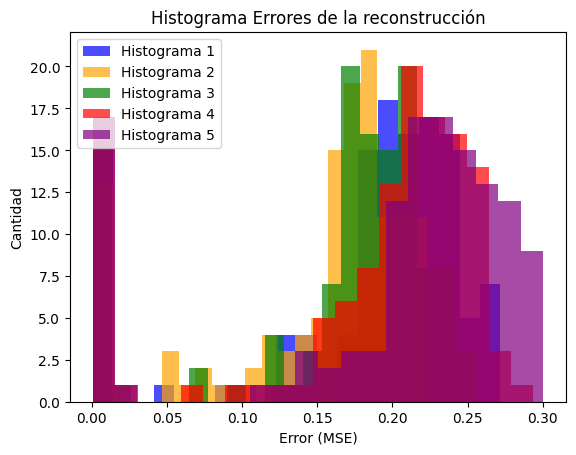

In [60]:

Corriente11 = pd.read_csv(r'11.csv', sep=';')
Corriente12 = pd.read_csv(r'12.csv', sep=';')
Corriente13 = pd.read_csv(r'13.csv', sep=';')
Corriente14 = pd.read_csv(r'14.csv', sep=';')
Corriente11 = ElimFechaDF(Corriente11)
Corriente12 = ElimFechaDF(Corriente12)
Corriente13 = ElimFechaDF(Corriente13)
Corriente14 = ElimFechaDF(Corriente14)
Corriente1.head()

Corr_interp_test = np.array([InterpolArr(Corriente11), InterpolArr(Corriente12), InterpolArr(Corriente13), InterpolArr(Corriente14)])
C_C3_int_t = Corr_interp_test[:,1,:]
C_C4_int_t = Corr_interp_test[:,2,:]
C_C5_int_t = Corr_interp_test[:,3,:]
C_C6_int_t = Corr_interp_test[:,4,:]
C_C7_int_t = Corr_interp_test[:,5,:]
X_test_c3 = dividir_senal_2(normalizar_array_2(C_C3_int_t))
X_test_c4 = dividir_senal_2(normalizar_array_2(C_C4_int_t))
X_test_c5 = dividir_senal_2(normalizar_array_2(C_C5_int_t))
X_test_c6 = dividir_senal_2(normalizar_array_2(C_C6_int_t))
X_test_c7 = dividir_senal_2(normalizar_array_2(C_C7_int_t))


a, _ = X_test_c3.shape
errors = [[] for _ in range(5)]


for i in range(a):
    #Caja 3
    serie_input = np.expand_dims(X_test_c3[i], axis=0)
    prediccion = modelo_c3.predict(serie_input)
    errors[0].append(np.mean((serie_input - prediccion) ** 2))
    #Caja 4
    serie_input = np.expand_dims(X_test_c4[i], axis=0)
    prediccion = modelo_c3.predict(serie_input)
    errors[1].append(np.mean((serie_input - prediccion) ** 2))
    #Caja 5
    serie_input = np.expand_dims(X_test_c5[i], axis=0)
    prediccion = modelo_c3.predict(serie_input)
    errors[2].append(np.mean((serie_input - prediccion) ** 2))
    #Caja 6
    serie_input = np.expand_dims(X_test_c6[i], axis=0)
    prediccion = modelo_c3.predict(serie_input)
    errors[3].append(np.mean((serie_input - prediccion) ** 2))
    #Caja 7
    serie_input = np.expand_dims(X_test_c7[i], axis=0)
    prediccion = modelo_c3.predict(serie_input)
    errors[4].append(np.mean((serie_input - prediccion) ** 2))


plt.figure()

# Trazar los histogramas
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
labels = ['Histograma 1', 'Histograma 2', 'Histograma 3',
          'Histograma 4', 'Histograma 5', 'Histograma 6']
for i in range(len(errors)):
    plt.hist(errors[i], bins=20, color=colors[i], alpha=0.7, label=labels[i])

# Configurar etiquetas y título
plt.ylabel('Cantidad')
plt.xlabel('Error (MSE)')
plt.title('Histograma Errores de la reconstrucción')

# Agregar leyenda
plt.legend()

# Mostrar el gráfico
plt.show()




Prueba con corrientes con falla de barra

C:\Users\Carlos\AppData\Local\Temp\ipykernel_19888\3584001430.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['DateTime'] = df['DateTime'].str.replace(".000", ".001")


1/1 [==============================] - 0s 34ms/step


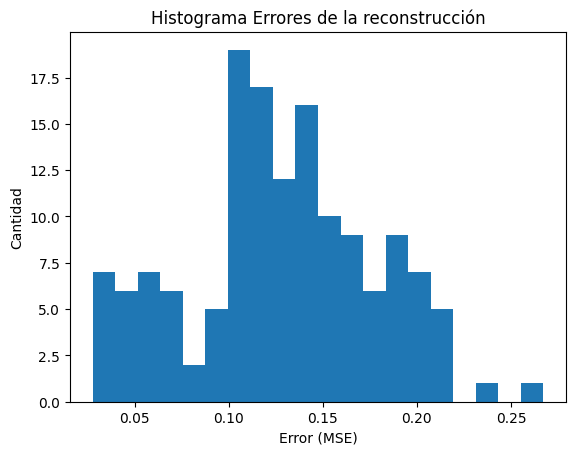

In [59]:

Corriente15 = pd.read_csv(r'15.csv', sep=';')

Corriente15 = ElimFechaDF(Corriente15)


Corriente15.head()

Corr_interp_test_falla = np.array([InterpolArr(Corriente15)])


C_C3_int_f = Corr_interp_test_falla[:,1,:]
C_C4_int_f = Corr_interp_test_falla[:,2,:]
C_C5_int_f = Corr_interp_test_falla[:,3,:]
C_C6_int_f = Corr_interp_test_falla[:,4,:]
C_C7_int_f = Corr_interp_test_falla[:,5,:]
X_falla_c3 = dividir_senal_2(normalizar_array_2(C_C3_int_f))
X_falla_c4 = dividir_senal_2(normalizar_array_2(C_C4_int_f))
X_falla_c5 = dividir_senal_2(normalizar_array_2(C_C5_int_f))
X_falla_c6 = dividir_senal_2(normalizar_array_2(C_C6_int_f))
X_falla_c7 = dividir_senal_2(normalizar_array_2(C_C7_int_f))
a, _ = X_falla_c3.shape
Error = []
modelo_g=[modelo_c3, modelo_c4, modelo_c5, modelo_c6, modelo_c7]
X_falla_g = [X_falla_c3, X_falla_c4, X_falla_c5, X_falla_c6, X_falla_c7]
for i in range(a):
    for k in range(5):
        serie_input = np.expand_dims(X_falla_g[k][i], axis=0)
        prediccion = modelo_g[k].predict(serie_input)
        
        Error.append(np.mean((serie_input - prediccion) ** 2))
        if Error[i]>0.5:
            print("Falla Reconstrucción con error de la caja ",k, ": ", Error[i])
            eje_x = range(100)

            # Graficar la serie original en azul
            plt.plot(eje_x, serie_input[0], color='blue', label='Original')

            # Graficar la serie predicha en rojo
            plt.plot(eje_x, prediccion[0], color='red', label='Predicción')

            # Configurar el título y las etiquetas de los ejes
            plt.title('Comparación de la serie original y la predicción')
            plt.xlabel('Tiempo')
            plt.ylabel('Valor')

            # Mostrar una leyenda con las etiquetas de las series
            plt.legend()

            # Mostrar la gráfica
            plt.show()


plt.hist(Error, 20)
plt.ylabel('Cantidad')
plt.xlabel('Error (MSE)')
plt.title('Histograma Errores de la reconstrucción')
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=82919a4a-c6cf-4593-8376-8c7458e8a304' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>